<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/AIcontents/refactored/refactoring_emo_ner_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion

In [1]:
! pip install -q tensorflow-text
! pip install -q tf-models-official

     |████████████████████████████████| 4.4 MB 8.0 MB/s 
     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 90 kB 12.6 MB/s 
     |████████████████████████████████| 211 kB 68.0 MB/s 
     |████████████████████████████████| 37.1 MB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 51.8 MB/s 
     |████████████████████████████████| 352 kB 55.6 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 58.6 MB/s 
     |████████████████████████████████| 636 kB 60.7 MB/s 
     |████████████████████████████████| 99 kB 12.2 MB/s 


In [2]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)

Mounted at /content/mnt


In [3]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2"
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 1
seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/final_train_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/final_train_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Arabian_test_data',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1333 files belonging to 4 classes.
Using 1067 files for training.
Found 1333 files belonging to 4 classes.
Using 266 files for validation.
Found 172 files belonging to 4 classes.


In [5]:
for text_batch, label_batch in train_ds.take(3):
  print(f'Review: {text_batch.numpy()[0]}')
  label = label_batch.numpy()[0]
  print(f'Label : {label} ({class_names[label]})')
  text_test = [text_batch.numpy()[0]]
  text_preprocessed = PREPROCESS_MODEL(text_test)
  print(f'Keys       : {list(text_preprocessed.keys())}')
  print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
  print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
  print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
  print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}\n')

  from tensorflow.keras import layers

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(4, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

Review: b'SILENCE.'
Label : 2 (2)
Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 4223 1012  102    0    0    0    0    0    0    0    0]
Input Mask : [1 1 1 1 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'al - der ice heard thetramp hiss of feet and looked round, only glad that if at all last she could see only the queen.'
Label : 1 (1)
Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2632  1011  4315  3256  2657  1996  6494  8737 19074  1997  2519]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'al - ice he was having too much vexed me to ever speak, and for she first had nev - er, in making all save her life, beentalked to in that overly rude way.'
Label : 2 (2)
Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2632  1011  3256  2002  2001  2383  2205  

tf.Tensor([[0.5890028 0.5894032 0.6467325 0.6537722]], shape=(1, 4), dtype=float32)
Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/3
1067/1067 [==============================] - 208s 182ms/step - loss: 1.3376 - sparse_categorical_accuracy: 0.6186 - val_loss: 0.9006 - val_sparse_categorical_accuracy: 0.8083
Epoch 2/3
1067/1067 [==============================] - 95s 89ms/step - loss: 0.5588 - sparse_categorical_accuracy: 0.8847 - val_loss: 0.8166 - val_sparse_categorical_accuracy: 0.8496
Epoch 3/3
172/172 [==============================] - 25s 141ms/step - loss: 2.0561 - sparse_categorical_accuracy: 0.7326
Loss: 2.0561373233795166
Accuracy: 0.7325581312179565
dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


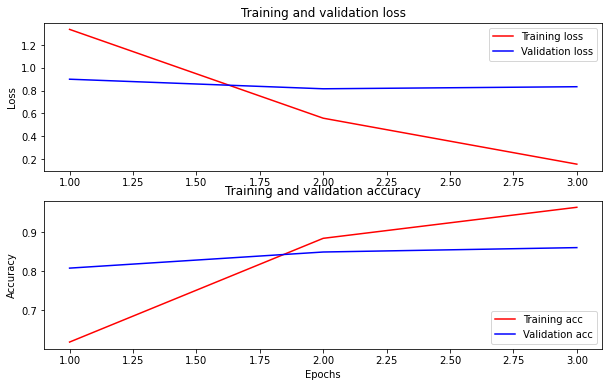

In [6]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
! pip install -q tf-models-official
from official.nlp import optimization

loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metric)

print(f'Training model with {BERT_MODEL}')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[es])

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [7]:
import numpy as np
predictions = classifier_model.predict(test_ds)
print(len(predictions))
print(predictions[0])
c=0
result_df=pd.DataFrame(columns=['sentence','mark','predicted_mark'])

for example in test_ds:
  #print('sentence:',example[0].numpy()[0])
  #print('mark:',example[1].numpy()[0],'predicted mark:',np.argmax(predictions[c]))
  result_df=result_df.append({'sentence':example[0].numpy()[0],
                              'mark':example[1].numpy()[0], 
                              'predicted_mark':np.argmax(predictions[c])},ignore_index=True)
  c+=1

#print(predictions)
display(result_df)
result_df.to_csv('./result.csv')

172
[0.9713136  0.5566956  0.01168145 0.4691757 ]


,sentence,mark,predicted_mark
0,b' The next day the merchant began to settle h...,3,0
1,"b' Fisherman, he said, the fish you have broug...",3,0
2,b' Of course it was not long before his reputa...,2,2
3,b' The three ladies were pleased with the song...,1,1
4,b' What an unlucky man I am to have freed you.',2,0
...,...,...,...
167,b' So I shall kill you.',2,2
168,b' At these words Amina fetched a lute from a ...,0,1
169,b' At the end of two days he lifted the trapdo...,0,0
170,b' For on the door was written in letters of g...,2,2


# NER

In [8]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-09-20 16:14:15--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-09-20 16:14:15--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-09-20 16:14:15 (48.9 MB/s) - written to stdout [1608/1608]

setup Cola

In [9]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')\
        .setCustomBounds(['\n'])

    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline

In [10]:
conll_pipeline = get_ann_pipeline ()

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]
Spark NLP NER lightpipeline is created


In [11]:
parsed = conll_pipeline.annotate ("Peter Parker Baker is in a baby blue Cadillac.")

for key in parsed.keys():
    print(key,': ',parsed[key])
conll_lines=''

for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

    conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)


print(conll_lines)

document :  ['Peter Parker Baker is in a baby blue Cadillac.']
ner_chunk :  ['Peter Parker Baker', 'Cadillac']
pos :  ['NNP', 'NNP', 'NNP', 'VBZ', 'IN', 'DT', 'NN', 'JJ', 'NNP', '.']
token :  ['Peter', 'Parker', 'Baker', 'is', 'in', 'a', 'baby', 'blue', 'Cadillac', '.']
ner :  ['B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O']
embeddings :  ['Peter', 'Parker', 'Baker', 'is', 'in', 'a', 'baby', 'blue', 'Cadillac', '.']
sentence :  ['Peter Parker Baker is in a baby blue Cadillac.']
Peter NNP NNP B-PER
Parker NNP NNP I-PER
Baker NNP NNP I-PER
is VBZ VBZ O
in IN IN O
a DT DT O
baby NN NN O
blue JJ JJ O
Cadillac NNP NNP B-ORG
. . . O



In [12]:
sentences=['Peter Parker Baker is in a baby blue Cadillac.','I love you.','Hanhee fell a sleep']

def get_person_entity(sentences):
  data=[]
  for sentence in sentences:
    parsed = conll_pipeline.annotate (sentence)
    line_entity=[]

    if 'B-PER' in parsed['ner']:
      for i in range(len(parsed['ner'])):
        if parsed['ner'][i]=='B-PER':
          name=parsed['embeddings'][i]
          line_entity.append(name)
        elif parsed['ner'][i]=='I-PER':
          line_entity[-1]+=' '+parsed['embeddings'][i]
      data.append(line_entity)
    else:
      data.append(line_entity)
    print(line_entity)
  return data

print(get_person_entity(sentences))

['Peter Parker Baker']
[]
['Hanhee']
[['Peter Parker Baker'], [], ['Hanhee']]


In [13]:
import pandas as pd
df=pd.read_csv('result.csv')
df['person']=get_person_entity(df['sentence'])
display(df)
df.to_csv('Entity_Predicted_result.csv')

[]
['Fisherman']
[]
[]
[]
['Sultan']
[]
[]
[]
[]
[]
[]
['Grant']
[]
[]
[]
[]
['vizir']
[]
[]
['Zobeida']
[]
['Heaven']
[]
[]
[]
[]
['Rejoice']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Douban']
[]
[]
['Sultan']
[]
[]
['Zobeida']
[]
[]
['Alnaschar']
[]
[]
['Sultan']
[]
[]
['Marzavan']
[]
[]
['Zobeida']
['Sadie']
[]
[]
[]
['Hindbad']
['King Armanos']
[]
[]
[]
[]
[]
['Sultan']
[]
[]
[]
[]
[]
[]
['Zobeida']
[]
['Sultan']
[]
['Hasten']
['Sultan']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Zobeida']
[]
['Sadia']
[]
[]
[]
[]
[]
[]
[]
['Zobeida', 'Sadie', 'Amina']
[]
[]
[]
[]
[]
[]
[]
['Rejoice']
[]
['Mad']
['Saouy']
[]
[]
[]
[]
['Zobeida']
[]
[]
['Sultan']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Zobeida', 'Calenders']
[]
[]
['Wretch']
[]
[]
[]
[]
[]
[]
['Sultan', "Aladdin's", 'Sultan']
[]
['O Fortune']
[]
['Alas']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Amina', 'Sadie']
[]
['Whoso']
[]


,Unnamed: 0,sentence,mark,predicted_mark,person
0,0,b' The next day the merchant began to settle h...,3,0,[]
1,1,"b' Fisherman, he said, the fish you have broug...",3,0,[Fisherman]
2,2,b' Of course it was not long before his reputa...,2,2,[]
3,3,b' The three ladies were pleased with the song...,1,1,[]
4,4,b' What an unlucky man I am to have freed you.',2,0,[]
...,...,...,...,...,...
167,167,b' So I shall kill you.',2,2,[]
168,168,b' At these words Amina fetched a lute from a ...,0,1,"[Amina, Sadie]"
169,169,b' At the end of two days he lifted the trapdo...,0,0,[]
170,170,b' For on the door was written in letters of g...,2,2,[Whoso]


# Data화

In [14]:
data=pd.read_csv('Entity_Predicted_result.csv')
display(data)

,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person
0,0,0,b' The next day the merchant began to settle h...,3,0,[]
1,1,1,"b' Fisherman, he said, the fish you have broug...",3,0,['Fisherman']
2,2,2,b' Of course it was not long before his reputa...,2,2,[]
3,3,3,b' The three ladies were pleased with the song...,1,1,[]
4,4,4,b' What an unlucky man I am to have freed you.',2,0,[]
...,...,...,...,...,...,...
167,167,167,b' So I shall kill you.',2,2,[]
168,168,168,b' At these words Amina fetched a lute from a ...,0,1,"['Amina', 'Sadie']"
169,169,169,b' At the end of two days he lifted the trapdo...,0,0,[]
170,170,170,b' For on the door was written in letters of g...,2,2,['Whoso']


In [15]:
#등장인물 추출
import ast
persons=[]

for person_line in data['person']:
  person_line = ast.literal_eval(person_line) 
  for p in person_line:
    persons.append(p)
persons=set(persons)
print(persons)
display(data)

{'Sultan', 'King Armanos', 'Alas', 'Hindbad', 'Mad', 'Grant', 'Sadia', 'Alnaschar', 'Wretch', 'Hasten', 'Whoso', 'Zobeida', 'Sadie', 'Calenders', 'Amina', 'Heaven', 'O Fortune', "Aladdin's", 'vizir', 'Douban', 'Saouy', 'Marzavan', 'Fisherman', 'Rejoice'}


,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person
0,0,0,b' The next day the merchant began to settle h...,3,0,[]
1,1,1,"b' Fisherman, he said, the fish you have broug...",3,0,['Fisherman']
2,2,2,b' Of course it was not long before his reputa...,2,2,[]
3,3,3,b' The three ladies were pleased with the song...,1,1,[]
4,4,4,b' What an unlucky man I am to have freed you.',2,0,[]
...,...,...,...,...,...,...
167,167,167,b' So I shall kill you.',2,2,[]
168,168,168,b' At these words Amina fetched a lute from a ...,0,1,"['Amina', 'Sadie']"
169,169,169,b' At the end of two days he lifted the trapdo...,0,0,[]
170,170,170,b' For on the door was written in letters of g...,2,2,['Whoso']


In [16]:
connection=[]
connections=[]

for p in data['person']:
  p=ast.literal_eval(p)
  if p:
    connection.append(p)
    if len(connection)>2:connection.pop(0)
  c=sum(connection, [])
  connections.append(set(c))
data['connection']=connections
display(data)
data.to_csv('connection_Predicted_result.csv')

,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person,connection
0,0,0,b' The next day the merchant began to settle h...,3,0,[],{}
1,1,1,"b' Fisherman, he said, the fish you have broug...",3,0,['Fisherman'],{Fisherman}
2,2,2,b' Of course it was not long before his reputa...,2,2,[],{Fisherman}
3,3,3,b' The three ladies were pleased with the song...,1,1,[],{Fisherman}
4,4,4,b' What an unlucky man I am to have freed you.',2,0,[],{Fisherman}
...,...,...,...,...,...,...,...
167,167,167,b' So I shall kill you.',2,2,[],"{Alas, O Fortune}"
168,168,168,b' At these words Amina fetched a lute from a ...,0,1,"['Amina', 'Sadie']","{Amina, Alas, Sadie}"
169,169,169,b' At the end of two days he lifted the trapdo...,0,0,[],"{Amina, Alas, Sadie}"
170,170,170,b' For on the door was written in letters of g...,2,2,['Whoso'],"{Amina, Sadie, Whoso}"


In [17]:
#################
#  0 : 중립      #
#  1 : 행복      #
#  2 : 분노      #
#  3 : 슬픔      #
#################

# 관계도 DB 구성
graph_keys=[]
graph_values=[]

import itertools
for i in range(len(data)):
  if len(data.loc[i]['connection'])>=2:
    comb=itertools.combinations(data.loc[i]['connection'],2)
    for c in comb:
      if c in graph_keys:
        graph_values[graph_keys.index(c)][data.loc[i]['predicted_mark']]+=1
      else:
        graph_keys.append(c)
        graph_values.append([0,0,0,0])
        graph_values[graph_keys.index(c)][data.loc[i]['predicted_mark']]+=1

print(graph_keys)
print(graph_values)

print(len(graph_keys))
print(len(graph_values))

connection_data=pd.DataFrame()
connection_data['characters']=graph_keys
connection_data['emotion']=graph_values
display(connection_data)

[('Fisherman', 'Sultan'), ('Grant', 'Sultan'), ('Grant', 'vizir'), ('Zobeida', 'vizir'), ('Zobeida', 'Heaven'), ('Heaven', 'Rejoice'), ('Rejoice', 'Douban'), ('Sultan', 'Douban'), ('Zobeida', 'Sultan'), ('Zobeida', 'Alnaschar'), ('Alnaschar', 'Sultan'), ('Marzavan', 'Sultan'), ('Zobeida', 'Marzavan'), ('Zobeida', 'Sadie'), ('Sadie', 'Hindbad'), ('King Armanos', 'Hindbad'), ('King Armanos', 'Sultan'), ('Sultan', 'Hasten'), ('Hasten', 'Sultan'), ('Zobeida', 'Sadia'), ('Sadia', 'Amina'), ('Sadia', 'Sadie'), ('Sadia', 'Zobeida'), ('Amina', 'Sadie'), ('Amina', 'Zobeida'), ('Sadie', 'Zobeida'), ('Zobeida', 'Amina'), ('Zobeida', 'Rejoice'), ('Amina', 'Rejoice'), ('Sadie', 'Rejoice'), ('Mad', 'Rejoice'), ('Mad', 'Saouy'), ('Saouy', 'Zobeida'), ('Zobeida', 'Calenders'), ('Calenders', 'Sultan'), ('Zobeida', 'Wretch'), ('Calenders', 'Wretch'), ("Aladdin's", 'Wretch'), ("Aladdin's", 'Sultan'), ('Wretch', 'Sultan'), ("Aladdin's", 'O Fortune'), ('Sultan', 'O Fortune'), ('Alas', 'O Fortune'), ('Amina

,characters,emotion
0,"(Fisherman, Sultan)","[0, 3, 2, 2]"
1,"(Grant, Sultan)","[2, 0, 1, 2]"
2,"(Grant, vizir)","[2, 0, 1, 0]"
3,"(Zobeida, vizir)","[0, 1, 1, 0]"
4,"(Zobeida, Heaven)","[0, 2, 1, 2]"
5,"(Heaven, Rejoice)","[0, 2, 3, 5]"
6,"(Rejoice, Douban)","[2, 1, 0, 0]"
7,"(Sultan, Douban)","[0, 1, 1, 1]"
8,"(Zobeida, Sultan)","[4, 8, 12, 5]"
9,"(Zobeida, Alnaschar)","[1, 1, 1, 0]"
